# Bayesian Statistical Inference

G. Richards
(2016, 2018, 2020, 2022)
with input from Ivezic $\S5$, Bevington, Karen Leighly's [Bayesian Stats](http://seminar.ouml.org/lectures/bayesian-statistics/) and [MCMC](http://seminar.ouml.org/lectures/monte-carlo-markov-chain-mcmc/) lectures, and [Thomas Wiecki](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).  With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s21).


##### Highly recommended supplemental background reading:

- [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686)
- [Jake VanderPlas: "Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)

## Contents
* [Bayesian Statistical Inference](#one)
* [Bayesian Priors](#two)
* [Heteroscedastic Gaussian with Bayesian Priors](#three)
* [Model Comparison](#four)
* [Example: Coin Flip](#five)
* [Monte Carlo Methods & Markov Chains](#six)
* [The Metropolis-Hastings Algorithm](#seven)
* [MCMC Example](#eight)

If you haven't already, please pause for a few minutes and install these two packages `emcee` and `pymc3` before going through today's notebook.

```
conda install -c default -c conda-forge emcee
conda install pymc3
```

## Bayesian Statistical Inference (Ivezic 5.0, 5.1)  <a class="anchor" id="one"></a>

Up to now we have been computing the **likelihood** $p(D|M)$.  In Bayesian inference, we instead evaluate the **posterior probability** taking into account **prior** information.

Recall from the BasicStats lecture that Bayes' Rule is:
$$p(M|D) = \frac{p(D|M)p(M)}{p(D)},$$
where $D$ is for data and $M$ is for model.

We wrote this in words as:
$${\rm Posterior Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

If we explicitly recognize prior information, $I$, and the model parameters, $\theta$, then we can write:
$$p(M,\theta|D,I) = \frac{p(D|M,\theta,I)p(M,\theta|I)}{p(D|I)},$$
where we can omit the explict dependence on $\theta$ by writing $M$ instead of $M,\theta$ where appropriate.  

Note that it is often that case that $p(D|I)$ is not evaluated explictly since the likelihood can be normalized such that the "evidence" is unity.

The Bayesian Statistical Inference process is then
* formulate the likelihood, $p(D|M,\theta,I)$, which is what we have been talking about so far
* chose a prior, $p(M,\theta|I)$, which incorporates other information beyond the data in $D$
* determine the posterior pdf, $p(M,\theta|D,I)$
* search for the model paramters that maximize the posterior pdf
* quantify the uncertainty of the model parameter estimates
* perform model selection to find the most appropriate description of the data

How does our answer change for our earlier example if we include a Bayesian prior (like we assumed for the IQ problem) and instead maximize the posterior probability?

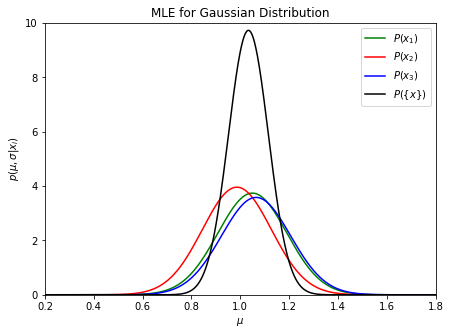

Posterior PDF is maximized at 1.033


In [2]:
#Load up the algorithms we are going to need.
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
%matplotlib inline

#Complete
N = 3 
mu = 1.0
sigma = 0.2 
np.random.seed(42)
sample = norm(mu,sigma).rvs(N)

xgrid = np.linspace(0,2,1000)
L1 = norm.pdf(xgrid,loc=sample[0],scale=sigma)
L2 = norm.pdf(xgrid,loc=sample[1],scale=sigma)
L3 = norm.pdf(xgrid,loc=sample[2],scale=sigma)

#New things
Prior = norm.pdf(xgrid,loc=mu,scale=sigma) #Prior PDF
Post1 = L1*Prior #Posterior PDF for the first measurement
Post2 = L2*Prior
Post3 = L3*Prior
Post = Post1*Post2*Post3 #Total posterior PDF for all the measurements

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, Post1, ls='-', c='green', label=r'$P(x_1)$')
plt.plot(xgrid, Post2, ls='-', c='red', label=r'$P(x_2)$')
plt.plot(xgrid, Post3, ls='-', c='blue', label=r'$P(x_3)$')
plt.plot(xgrid, Post/5, ls='-', c='black', label=r'$P(\{x\})$') #Scaled for the sake of display

plt.xlim(0.2, 1.8)
plt.ylim(0, 10.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(\mu,\sigma|x_i)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show()

idx = np.argsort(Post)
print("Posterior PDF is maximized at %.3f" % xgrid[idx[-1]])

See what happens when you have just 2 measurements, but one has a much larger error than the other (i.e., the errors are heteroscedastic).

Likelihood is maximized at 1.097


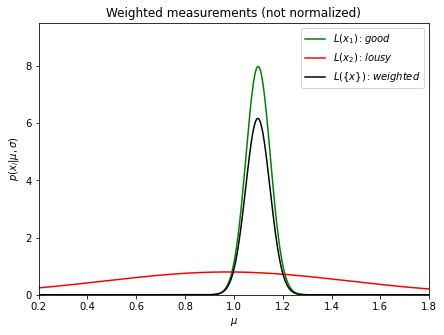

In [3]:
L1 = norm.pdf(xgrid,loc=sample[0],scale=0.05) #Measurement with small error
L2 = norm.pdf(xgrid,loc=sample[1],scale=0.5) #Measurement with large error (give it a very different location parameter)
L = L1 * L2 
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, L1, ls='-', c='green', label=r'$L(x_1): good$')
plt.plot(xgrid, L2, ls='-', c='red', label=r'$L(x_2): lousy$')
plt.plot(xgrid, L, ls='-', c='black', label=r'$L(\{x\}): weighted$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 9.5)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Weighted measurements (not normalized)')
plt.legend()

idx = np.argsort(L)
print("Likelihood is maximized at %.3f" % xgrid[idx[-1]])

## Bayesian Priors (Ivezic 5.2)  <a class="anchor" id="two"></a>

Priors can be **informative** or **uninformative**.  As it sounds, informative priors are based on existing information that might be available.  Uninformative priors can be thought of as "default" priors, i.e., what your prior is if you weren't explicitly including a prior, e.g, a "flat" prior like $p(\theta|M,I) \propto {\rm C}$.

For the IQ test example, what kind of prior did we use?

In a *hierarchical Bayesian* analysis the priors themselves can have parameters and priors (hyperparameters and hyperpriors), but let's not worry about that for now.

While determining good priors is important for Bayesian analysis, I don't want to get distracted by it here.  You can read more about it in Ivezic, 5.2.  However, I'll briefly introduce 3 principles here.

### The Principle of Indifference

Essentially this means adopting a uniform prior, though you have to be a bit careful.  Saying that an asteroid is equally likely to hit anywhere on the Earth is not the same as saying that all latitudes of impact are equally likely.  Assuming $1/6$ for a six-side die would be an example of indifference.

### The Principle of Invariance (or Consistency)

This applies to location and scale invariance.  

**Location invariance** suggests a uniform prior, within the accepted bounds: $p(\theta|I) \propto 1/(\theta_{max}-\theta_{min})$ for $\theta_{min} \le \theta \le \theta_{max}$. 

**Scale invariance** gives us priors that look like $p(\theta|I) \propto 1/\theta$, which implies a uniform
prior for ln($\theta$), i.e. a prior that gives equal weight over many orders of magnitude. 

### The Principle of Maximum Entropy

The principle of maximum entropy is discussed in Ivezic, 5.2.2.
It is often true that Bayesian analysis and traditional MLE are essentially equivalent.  However, in some cases, considering the priors can have significant consequences. 
See Ivezic $\S$5.5 for such an example.

## Analysis of a Heteroscedastic Gaussian distribution with Bayesian Priors (Ivezic 5.6)  <a class="anchor" id="three"></a>

Consider the case of measuring a rod as before, but now including a Bayesian Prior.  We want to know the posterior pdf for the length of the rod, $p(M,\theta|D,I) = p(\mu|\{x_i\},\{\sigma_i\},I)$.

For the likelihood we have
$$L = p(\{x_i\}|\mu,I) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

In the Bayesian case, we also need a prior.  We'll adopt a uniform distribution given by
$$p(\mu|I) = C, \; {\rm for} \; \mu_{\rm min} < \mu < \mu_{\rm max},$$
where $C = \frac{1}{\mu_{\rm max} - \mu_{\rm min}}$ between the min and max and is $0$ otherwise.

The log of the posterior pdf is then
$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

This is exactly the same as we saw before, except that the value of the constant is different.  Since the constant doesn't come into play, we get the same result as before:
 
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$
with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

We get the same result because we used a flat prior.  If the case were homoscedastic uncertainty instead of heteroscedastic, we obviously would get the result from our first example.

Now let's consider the case where $\sigma$ is not known, but rather needs to be determined from the data.  In that case, the posterior pdf that we seek is not $p(\mu|\{x_i\},\{\sigma_i\},I)$, but rather $p(\mu,\sigma|\{x_i\},I)$.

As before we have
$$L = p(\{x_i\}|\mu,\sigma,I) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$
except that now $\sigma$ is uknown instead of given (meaning we need to move it to the left of the "pipe").

Our Bayesian prior is now 2D instead of 1D and we'll adopt 
$$p(\mu,\sigma|I) \propto \frac{1}{\sigma},\; {\rm for} \; \mu_{\rm min} < \mu < \mu_{\rm max} \; {\rm and} \; \sigma_{\rm min} < \sigma < \sigma_{\rm max}.$$

That is, all values of $\mu$ are equally likely (within the range indicated), but we'll down-weight the likelihood of large errors (again limiting $\sigma$ to some range).  Note that the ranges actually drop out since they are constants.

With proper normalization, we have
$$p(\{x_i\}|\mu,\sigma,I)p(\mu,\sigma|I) = C\frac{1}{\sigma^{(N+1)}}\prod_{i=1}^N \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2}  \right),$$
where
$$C = (2\pi)^{-N/2}(\mu_{\rm max}-\mu_{\rm min})^{-1} \left[\ln \left( \frac{\sigma_{\rm max}}{\sigma_{\rm min}}\right) \right]^{-1}.$$



The log of the posterior pdf is

$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

Right now that has $x_i$ in it, which isn't that helpful, but since we are assuming a Gaussian distribution, we can take advantage of the fact that the mean, $\overline{x}$, and the variance, $V (=s^2)$, completely characterize the distribution.  So we can write this expression in terms of those variables instead of $x_i$.  Skipping over the math details (see Ivezic $\S$5.6.1), we find

$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \frac{N}{2\sigma^2}\left( (\overline{x}-\mu)^2 + V  \right).$$

Note that this expression only contains the 2 parameters that we are trying to determine: $(\mu,\sigma)$ and 3 values that we can determine directly from the data: $(N,\overline{x},V)$.

Load and execute the next cell to visualize the posterior pdf for the case of $(N,\overline{x},V)=(10,1,4)$.  Change `usetex=True` to `usetex=False` if you have trouble with the plotting.  Try changing the values of $(N,\overline{x},V)$.

C:\Users\Daniel\anaconda3\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


Text(0, 0.5, '$\\sigma$')

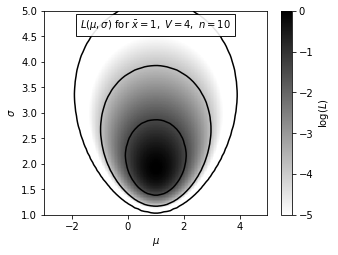

In [4]:
# Execute this cell
# %load code/fig_likelihood_gaussian.py
"""
Log-likelihood for Gaussian Distribution
----------------------------------------
Figure5.4
An illustration of the logarithm of the posterior probability density
function for :math:`\mu` and :math:`\sigma`, :math:`L_p(\mu,\sigma)`
(see eq. 5.58) for data drawn from a Gaussian distribution and N = 10, x = 1,
and V = 4. The maximum of :math:`L_p` is renormalized to 0, and color coded as
shown in the legend. The maximum value of :math:`L_p` is at :math:`\mu_0 = 1.0`
and :math:`\sigma_0 = 1.8`. The contours enclose the regions that contain
0.683, 0.955, and 0.997 of the cumulative (integrated) posterior probability.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=14, usetex=True)


def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.57: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)

#Change these to change the output posterior PDF
xbar = 1 # Mean as determined from the data
V = 4 # Variance as determined from the data
n = 10 # Total number of data points in the sample

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_likelihood_gaussian_1.png)

The shaded region is the posterior probability.  The contours are the confidence intervals.  We can compute those by determining the marginal distribution at each $(\mu,\sigma)$.  The top panels of the figures below show those marginal distributions.  The solid line is what we just computed.  The dotted line is what we would have gotten for a uniform prior--not that much difference.  The dashed line is the MLE result, which is quite different.  The bottom panels show the cumulative distribution.

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_posterior_gaussian_1.png)


Note that the marginal pdfs follow a Student's $t$ Distribution, which becomes Gaussian for large $N$.

- The main result here is that **for smallish N ($<$10 or so), $p(\mu)$ is not Gaussian!** 
- The code above can be used to compute $p(\mu)$ for arbitrary values of N, $\overline{x}$ and V.
- For large N, Gaussian is a good approximation of $p(\mu)$. 

What if we wanted to **model the mixture of a Gauassian distribution with a uniform distribution**. When might that be useful?  Well, for example, finding new particles!! The following is from the [Atlas bulletin](https://atlas.cern/updates/feature/higgs-boson) of July 4th, 2018, showing the Higgs boson peak embdded in background noise and other particles.

![Atlas Higgs Boson Example](https://cds.cern.ch/record/2627611/files/Higgsto4l.png?subformat=icon-640)

Obviously this isn't *exactly* a Gaussian and a uniform distribution, but a line feature superimposed upon a background is the sort of thing that a physicist or astronomer might see and is pretty close to this case for a local region around the feature of interest.

If we adopt a uniform prior in both $A$ and $\sigma$:
$$p(A,\sigma|I) = C, \; {\rm for} \; 0\le A<A_{\rm max} \; {\rm and} \; 0 \le \sigma \le \sigma_{\rm max},$$
then the posterior pdf is given by
$$\ln [p(A,\sigma|\{x_i\},\mu,W)] = \sum_{i=1}^N \ln \left[\frac{A}{\sigma \sqrt{2\pi}} \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2} \right)  + \frac{1-A}{W} \right].$$

The figure below (Ivezic, 5.13) shows an example for $N=200, A=0.5, \sigma=1, \mu=5, W=10$.  Specifically, the bottom panel is a result drawn from this distribution and the top panel is the likelihood distribution derived from the data in the bottom panel.
![Ivezic, Figure 5.13](http://www.astroml.org/_images/fig_likelihood_gausslin_1.png)

A more realistic example might be one where all three parameters are unknown: the location, the width, and the background level.  But that will have to wait until $\S$5.8.6.

In the meantime, note that we have not binned the data, $\{x_i\}$.  We only binned Figure 5.13 for the sake of visualizaiton.  However, sometimes the data are inherently binned (e.g., the detector is pixelated).  In that case, the data would be in the form of $(x_i,y_i)$, where $y_i$ is the number of counts at each location.  We'll skip over this example, but you can read about it in Ivezic $\S$5.6.6.  A refresher on the Poission distribution (Ivezic $\S$3.3.4) might be appropriate first.

### Recap

To review: the Bayesian Statistical Inference process is
* formulate the likelihood, $p(D|M,\theta,I)$
* chose a prior, $p(M,\theta|I)$, which incorporates other information beyond the data in $D$
* determine the posterior pdf, $p(M,\theta|D,I)$
* search for the model paramters that maximize the posterior pdf
* quantify the uncertainty of the model parameter estimates
* perform model selection to find the most apt description of the data

The last part we haven't talked about yet.

## Bayesian Model Comparison <a class="anchor" id="four"></a>

In the Bayesian context, to determine which model is better we can also compute the ratio of the posterior probabilities or the **odds ratio** for two models as
$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

Since 
$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$
the odds ratio can ignore $p(D|I)$ since it  will be the same for both models.  

(That is even more important than you might think as the denominator is the integral of the numerator, but what if you don't have an analytical function that you can integrate?!)

### How do we interpret the values of the odds ratio in practice?

Jeffreys proposed a five-step scale for interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

But note:
  * These are just **definitions of conventions**, i.e., a way to give a quantitative meaning to qualitative phrases.
  * The odds ratio **compares** the models, it doesn't tell us about the *absolute* goodness of fit: model A can be 100x better than model B, but still be pretty lousy.

### Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement.  That is $p(M_1) + p(M_2) = 1$.  If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

- In **classical hypothesis testing** we can ask whether or not a single model provides a good description of the data.  
- In **Bayesian hypothesis testing**, we need to have an alternative model to compare to.

## Coin Flip as an Example of Bayesian Model Comparison  <a class="anchor" id="five"></a>

Let's look at an example using coin flips. Let's assume we have $N$ draws and $k$ are "success" (say, heads). 

We will compare two hypotheses:

- **M1**: the coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), with a prior given by a delta function, $\delta(b-b_\ast)$
- **M2**: the heads probability $b$ is unknown, with a uniform prior in the range 0–1

Basically in **M1** we know about the fairness of the coin. In **M2** we don't know anything about the fairness of the coin.

The model that we need (parametrized by the probability of success $b$, with $k$ successes) is the binomial distribution (which we haven't talked about): 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model **M2** the prior for $b$ is flat in the range 0-1 and the product of the data likelihood and prior is same as above. However, for model **M1** the prior is a  delta function $\delta(b-b_\ast)$ and we get for the product of the data likelihood and prior (which picks out $b=b_\ast$) 
$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the odds ratio is given by 
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
as illustrated in the following figure. 

 
![Ivezic, Figure 5.1](http://www.astroml.org/_images/fig_odds_ratio_coin_1.png)

This figure (from the textbook) illustrates the behavior of $O_{21}$ as a function of $k$
for two different values of N and for two different values of $b_\ast$: $b_\ast = 0.5$ 
(M1: the coin is fair) and $b_\ast = 0.1$ (M1: the coin is biased to tails). 

*The ability to distinguish  the two hypothesis **improves** with the sample size.*

For example:
- when $b_\ast = 0.5$ and $b = k/N = 0.1$ ($k=1$ on the left and $k=2$ on the right), the odds ratio in favor of **M2** increases from $\sim 9$ for $N=10$ to $\sim 263$ for $N=20$. 
- when k = $b_\ast N$, the odds ratio is $0.37$ for $N=10$ and 0.27 for $N=20$. 
- **the simpler model is favored by the data**, and the support strengthens with the sample size. 

**NOTE** 
- *$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$.* 
- To build strong evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as $N > 157$ tosses. 
- With N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and the corresponding odds ratio is $O_{21} \approx 1/80$.

***Frequentist Versus Bayesian***

In the **frequentist approach**, we ask whether we can reject the "null hypothesis" that our coin is fair. Specifically, we ask whether a given $k$ is a very unusual outcome (at some significance level $\alpha$, say $\alpha=0.05$) for a fair coin with $b_\ast = 0.5$ and with a given N. 

In the **Bayesian approach**, we offer an alternative hypothesis that the coin has an unknown heads probability. While this probability can be estimated from provided data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed hypotheses. 

As a numerical example, let's consider N=20 and k=16. The scatter around the expected value $k_0 = b_\ast N$ = 10 is $\sigma_k = 2.24$. 
Therefore, k = 16 is about 2.7$\sigma_k$ away from $k_0$, and at the adopted significance 
level $\alpha=0.05$ we **reject the null hypothesis** (that our coin was fair).  This rejection means that it is unlikely that k = 16 would have arisen by chance). Of course, k = 16 does **not** imply 
that it is impossible that the coin is fair (infrequent events happen, too!).

As shown in the above figure, the chosen parameters (N=20 and k=16) correspond to the 
Bayesian **odds ratio** of about 10 in favor of hypothesis M2.  

If you want to learn about or get a refresher on classical inference in detail, you might go through the full set of videos on it at 
[Khan Academy](https://www.khanacademy.org/math/ap-statistics/tests-significance-ap)

## Monte Carlo Methods & Markov Chains <a class="anchor" id="six"></a>

### Motivation

Consider the problem of estimating location and scale parameters
for a sample drawn from a Gaussian distribution that we introduced earlier.
We had a two-dimensional posterior pdf for $\mu$ and $\sigma$:

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_likelihood_gaussian_1.png)


It was easy to numerically integrate the posterior pdf, as well 
as to find its maximum, using brute force grid search because
it was only a two-dimesional problem. With 100 grid points per
coordinate it was only $10^4$ values. 

However, **what about high parameter dimensions?**
- Even in a case of rather simple $5$D problem (as we'll discuss later today), we'd have $10^{10}$ values! And often we work with models of much higer dimensionality (it can be thousands!). **Brute-force grid methods are not feasible beyond a few dimensions**, and even then can be waste of time. 
- You could **simply randomly sample the grid at every point**, and try to find the minimum based on that. But that can also be quite time consuming, and you will spend a lot of time in regions of parameter space that yields small likelihood.

A better way is to adopt a **Markov-Chain Monte Carlo (MCMC)**. MCMC gives us a way to make this problem computationally tractable by sampling the full multi-dimensional parameter space, in a way that builds up the most density in the regions of parameter space which are closest to the maximum. Then, you can post-process the “chain” to infer the distribution and error regions.

Ivezic, Figure 5.22 shows a problem similar to the one above, done with a Markov Chain Monte Carlo.  The dashed lines are the known (analytic) solution.  The solid lines are from the MCMC estimate with 10,000 sample points.
![Ivezic, Figure 5.10](http://www.astroml.org/_images/fig_cauchy_mcmc_1.png)


## How does MCMC work?

I've really struggled to come up with a simple way of illustrating MCMC so that you (and I for that matter) can understand it.  Unfortunately, even the supposedly dumbed-down explanations are really technical.   But let's see what I can do!  

Let's start by simply trying to understand what a Monte Carlo is and what a Markov Chain is.

### What is a Monte Carlo?

In case you are not familiar with Monte Carlo methods, it might help to know that the term is derived from the name of an administrative area of the Principality of Monaco (Monte Carlo) where they are known for gambling.  And gambling and random sampling go together.

We'll consider a simple example: you have forgotten the value of $\pi$, but you know the formula for the area of a square and how to draw a circle. 

We can use the information that we *do* know to numerically compute $\pi$.

We start by drawing a square and circumscribing a circle in it (actually it suffices to just do a quarter of a circle and scale accordingly).  Then we put down random points within the square and note which ones land in the circle.  The ratio of random points in the circle to the number of random points drawn is related to the area of our circle, allowing us to calculate $\pi$.  Using more random points yields more precise estimates of the area.

Try it.

We'll consider one quadrant of a square of sides [0,1] in which we inscribe a circle (actually just one quarter of a circle).

Text(0, 0.5, 'y')

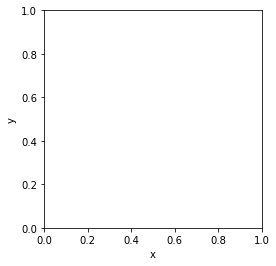

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
#ax.axis([0, 1, 0, 1], aspect='equal');
ax.axis([0, 1, 0, 1]);
plt.xlabel('x')
plt.ylabel('y')

Estimate of pi is 4.0 for 1000 draws with fractional error 0.2732395447351627.


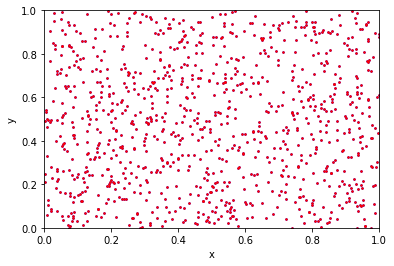

In [9]:
#Lay down M random points.  Tally how many are within a unit circle.
M = 1000
x = stats.uniform(0,1).rvs(M) #M random draws between 0 and 1
y = stats.uniform(0,1).rvs(M) #M random draws between 0 and 1
r2 = np.sqrt(x*x*+y*y) #Radius of cirle
fig, ax = plt.subplots(subplot_kw=dict())
plt.plot(x, y, '.k', markersize=3, c='blue') #Plot points in square
plt.plot(x[r2<1], y[r2<1], '.k', markersize=3, c='red') #Plot points also in circle
ax.axis([0, 1, 0, 1]);
plt.xlabel('x')
plt.ylabel('y')
    
#Asquare = d^2, Acircle = pi*d^2

piEst = 4.0*np.sum(r2<1)/M # pi = 4A/d^2, where A is d^2 times the ratio of points "in" to total points

print("Estimate of pi is {0} for {1} draws with fractional error {2}.".format(piEst,M,np.abs((np.pi-piEst)/np.pi)))

See how many draws does it take to get the error down to 1 part in a thousand?

See also [this Khan Academy simulation](https://www.khanacademy.org/computer-programming/monte-carlo-finding-the-value-of-pi/6530004791197696/embedded?embed=yes&article=yes&editor=no&buttons=no&author=no&autoStart=yes&width=610&height=420).

In general, Monte Carlo methods are about using random sampling to obtain a numerical result (e.g., the value of an integral), where there is no analytic result.

In the case of the circle above, we have computed the intergral:
$$\int\int_{x^2+y^2\le 1} dx dy.$$

### What is a Markov Chain?

A Markov Chain is defined as 
> a sequence of random variables where a parameter depends *only* on the preceding value.  

Such processes are "memoryless".  
 
Mathematically, we have
$$p(\theta_{i+1}|\{\theta_i\}) = p(\theta_{i+1}|\theta_i).$$

Now, if you are like me, you might look at that and say "Well, day 3 is based on day 2, which is based on day 1, so day 3 is based on day 1...".

So let's look at an example to see what we mean and how this might be a memoryless process.


Let's say that you are an astronomer and you want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy).  From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$
which means that
$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have
$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$
which means that
$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$

(That is, you don't live in Philadelphia.)

We can start with the sky conditions today and make predictions going forward.  This will look like a big decision tree.  After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$
and 
$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether is was clear to cloudy on the day that you started.    

The steps that we have taken in this process are a **Markov Chain**.

Here are illustration of the process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

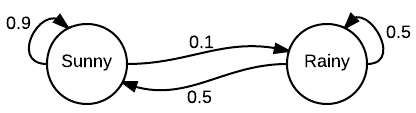

Sampling for 10,000 days using this prescription gives a chain that looks like this:

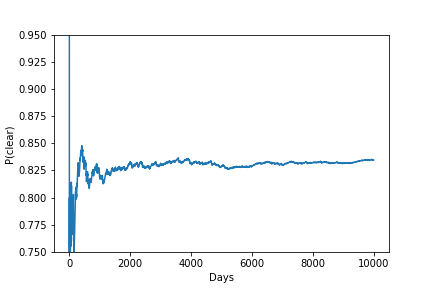
For homework, you will generate an equivalent plot, testing to see whether or not it matters if you start on a clear day or a cloudy day.

A histogram of the above plot reveals the distribution of p(clear) values over this time.  We can use this to determine the most likely value and an error on our estimate.

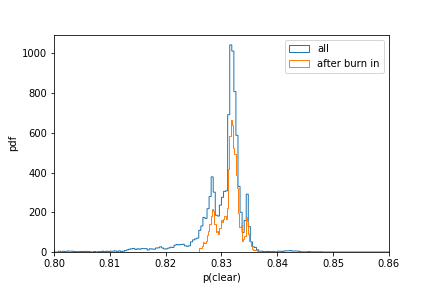

- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!!!***

The use of **Markov chains** to perform **Monte Carlo integration** is called ***Markov Chain Monte Carlo (MCMC)***

## The Metropolis-Hastings Algorithm <a class="anchor" id="seven"></a>

Most of the difficulty in the MCMC process comes from either determining the burn-in or deciding how to step from one position to another.  In our circle example we have drawn points in a completely random manner.  However, that may not be the most efficient manner to span the space.  

The most commonly used algorithm for stepping from one position to another is the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which consists of these steps:

1. Starting at a random position, evaluate the likelihood.
2. Choose a new position, according to some transition probabilities, and evaluate the likelihood there.
3. Examine the odds ratio formed by the new-position likelihood and the old-position likelihood. If the odds ratio is greater than 1, move to the new position.  If it is less than one, keep it under the following conditions: draw a random number between zero and 1.   If the odds ratio is larger than the random number, keep it. If not, reject the new position.
4. Repeat 1-3 many times. After a period of time (the burn-in) the simulation should reach an equilibrium. Keep the results of the chain (after burn-in), and postprocess those results to infer the likelihood surface.

***Step 3*** is very important. If we only accepted points of higher probability then we would only move up the posterior density to find its maximum. But we want to map out the full posterior density, so sometimes we must settle for less!

In astronomy, the ${\tt emcee}$ algorithm has become more popular in recent years.  We won't discuss either in detail, but both the [code](http://dan.iel.fm/emcee/current/) and a [paper](http://adsabs.harvard.edu/abs/2013PASP..125..306F) describing the ${\tt emcee}$ are available.

Recall that our parameter space is multidimensional.  So, when you are stepping from one point to another, you are really doing it in N-D parameter space!  You might wonder if you could just step one parameter at a time.  Sure!  That's what [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) does (and it is less likely to get stuck in a local minimum than Metropolis-Hastings).

### Corner Plots

If you are using MCMC, then you probably have multiple parameters (otherwise, you'd be doing something easier).  So, it helps to display the parameters two at a time, marginalizing over the other parameters.  An example is given in Ivezic, Figure 5.24, which compares the model results for a single Gaussian fit to a double Gaussian fit. These are called `corner` or `triangle` plots, which we've discussed before.

The most popular packages to make these are [corner](https://corner.readthedocs.io/en/latest/) and [chainconsumer](https://samreay.github.io/ChainConsumer/).

![Ivezic, Figure 5.24](http://www.astroml.org/_images/fig_model_comparison_mcmc_1.png)

## MCMC Example <a class="anchor" id="nine"></a>

We'll end by going through the example given at
[http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).

First set up some stuff by executing the next cell

In [10]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(123)

Now let's generate some data points and plot them.  We'll try a normal distribution, centered at 0 with 100 data points, using [numpy.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html).  Our goal is to estimate $\mu$.

Text(0, 0.5, 'N')

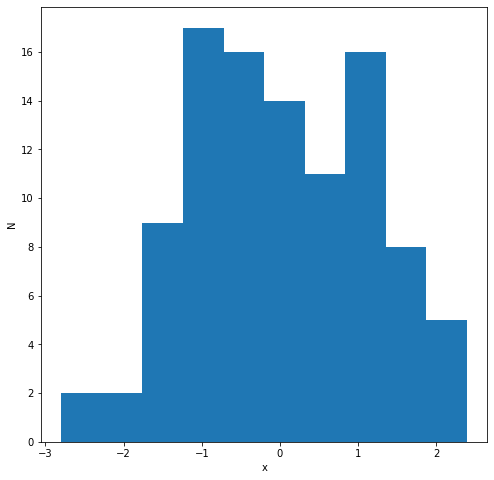

In [11]:
data = np.random.randn(100)
plt.figure(figsize=(8,8))
plt.hist(data)
plt.xlabel('x')
plt.ylabel('N')

Now we have to pick a model.

- We'll assume a Gaussian likelihood distribution: $\mathscr{N}(\mu,\sigma=1)$ (i.e., with $\sigma=1$).  
- We'll also assume a Gaussian distribution for the prior on $\mu$: $\mathscr{N}(0,1)$.

We can use that to write a function for our posterior distribution as follows (recalling from Lecture 3 the formula for the product of two Gaussians):

Text(0, 0.5, 'post prob')

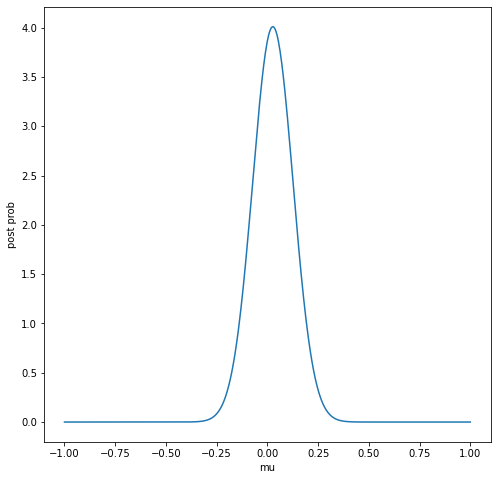

In [12]:
#Execute this cell
def calc_posterior_analytical(data, xgrid, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    #Error-weighted sum of prior and average of data
    #Recall from lecture 3 the formula for the product of 2 Gaussians
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    # This is the Gaussian for the prior: mu_0 / sigma_0**2
    # This is the Gaussian for the likelihood: data.sum() / sigma**2
    # We are deriving the mean from the sum of the data values
    var_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm.pdf(xgrid, mu_post, np.sqrt(var_post))

plt.figure(figsize=(8,8))
xgrid = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, xgrid, 0., 1.)
plt.plot(xgrid, posterior_analytical)
plt.xlabel('mu')
plt.ylabel('post prob')

Now we need to sample the distribution space.

- We'll start with a trial $\mu_0 = -1$ and evaluate.
- Then we'll jump to a new position using the Metropolis-Hastings algorithm mentioned above.  
- Next we evaluate whether that jump was "good" or not -- by seeing if the value of the likelihood $\times$ prior increases.    Now, we want to get the right answer, but we also want to make sure that we sample the full parameter space (so that we don't get stuck in a local minimum).  So, even if the this location is not better than the last one, we'll have some probability of staying there anyway.  

The reason that taking the ratio of likelihood\*prior works is that the denominator drops out.  That's good because the denominator is the integral of the numerator and that's what we are trying to figure out!  In short, we don't have to know the posterior probability to know that the posterior probability at one step is better than another.

Read through the first function below to understand how it is implementing the Metropolis-Hastings algorithm. But don't worry about the second function, which is just setting up plots.

In [14]:
# Execute this cell
# See https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb
def sampler(data, samples=4, mu_init=.5, proposal_width=0.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        # changing the width of this distribution changes how big the jump is between trials.
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        # Accept if p_accept>1 (since random limited to [0,1]) and if p_accept > rand as well
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    xgrid = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm.pdf(xgrid,mu_prior_mu, mu_prior_sd)
    ax1.plot(xgrid, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm.pdf(xgrid,loc=mu_proposal, scale=1)
    #sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.hist(data,alpha=0.5,density='True')
    ax2.plot(xgrid, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, xgrid, mu_prior_mu, mu_prior_sd)
    ax3.plot(xgrid, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler.

- **1st column = prior distribution**. The distribution is static and we are only plugging in our $\mu$ proposals. The vertical lines represent the current $\mu$ in blue and the proposed $\mu$ in either red or green (rejected or accepted, respectively).

- **2nd column = likelihood**.  The likelihood function changes in response to the proposed $\mu$. The blue histogram is the data. The solid line in green or red is the likelihood with the currently proposed $\mu$. The more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dashed line of the same color is the proposed mu and the dashed blue line is the current $\mu$.

- **3rd column = (normalized) posterior distribution**.

- **4th column = trace** (i.e. the posterior samples of $\mu$ we are generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values


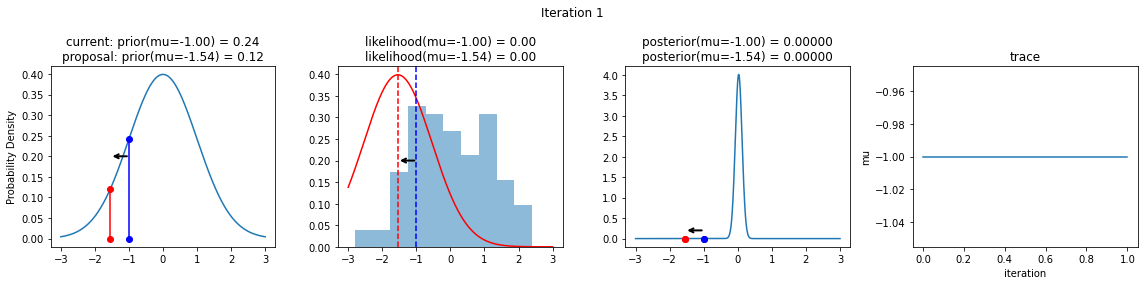

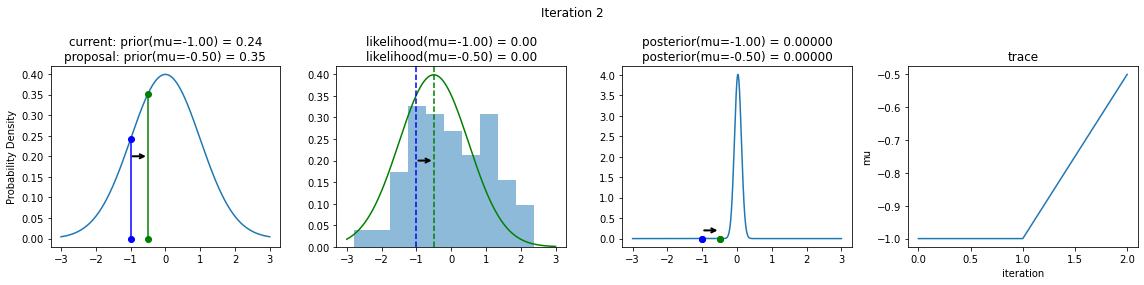

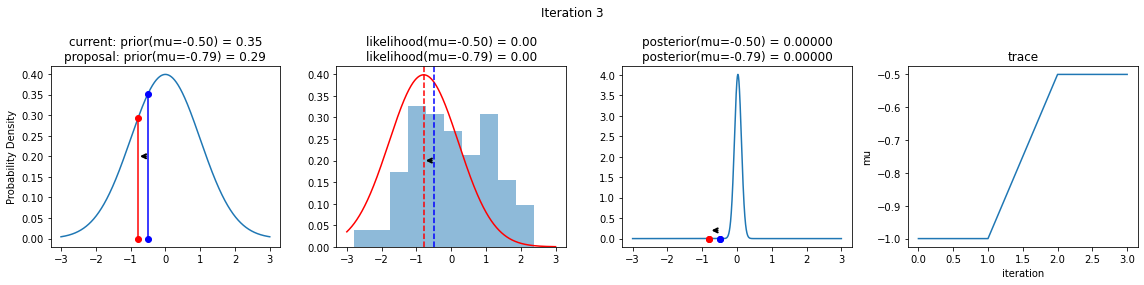

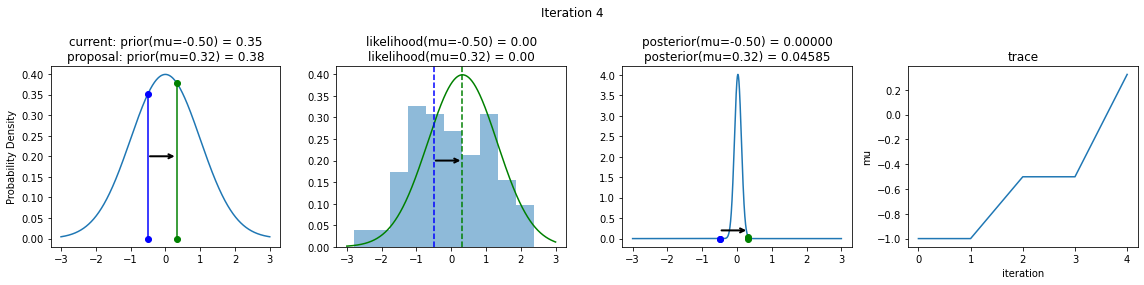

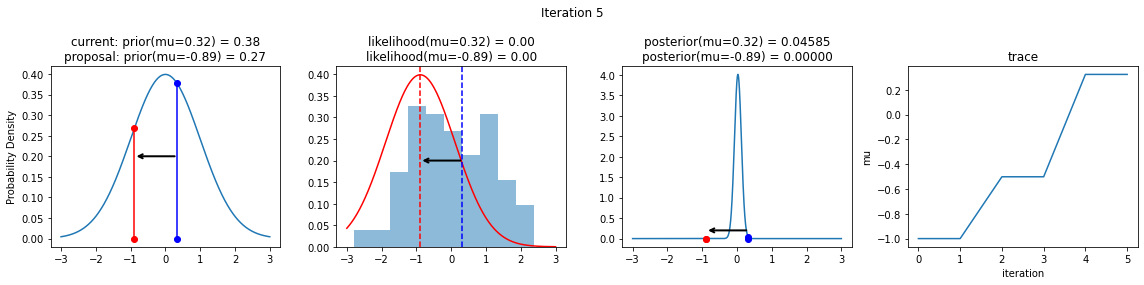

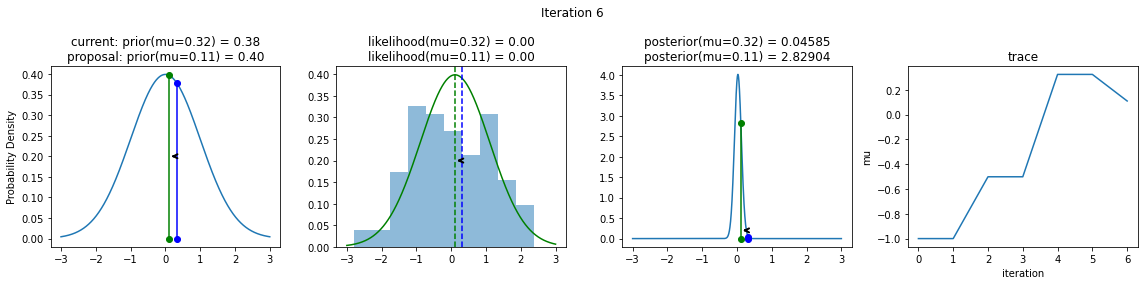

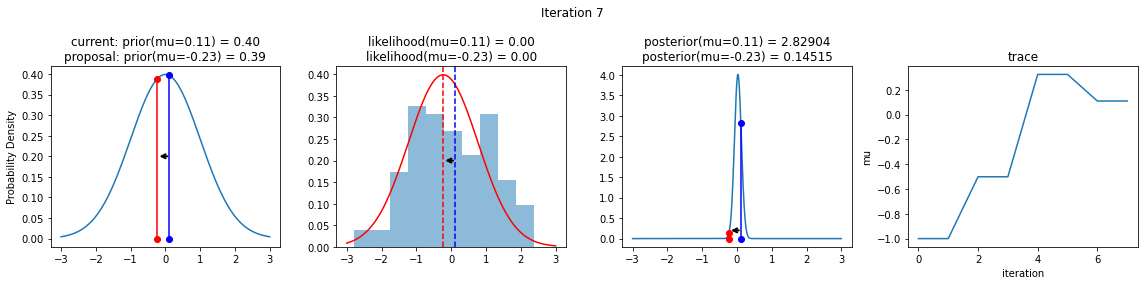

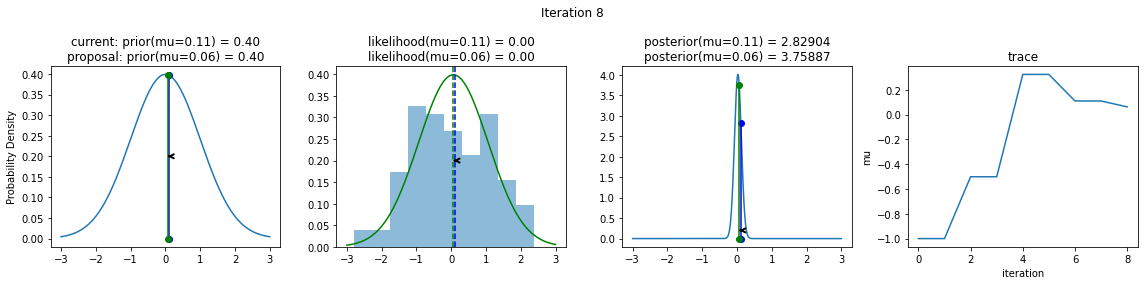

In [15]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

What happens when we do this lots of times?  (You might need to wait for a minute.)

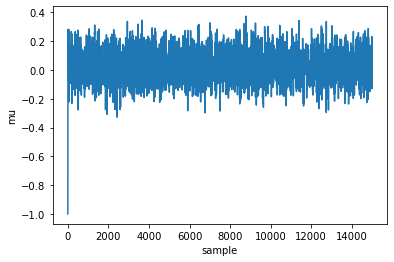

In [16]:
posterior = sampler(data, samples=15000, mu_init=-1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

Making a histogram of these results is our estimated posterior probability distribution.  (Let's remove the first $500$ points as burn-in.)

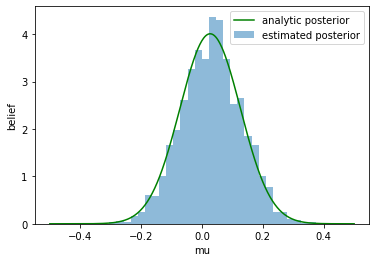

In [17]:
ax = plt.subplot()

burn = 500
ax.hist(posterior[burn:],bins=30,alpha=0.5,density='True',label='estimated posterior')
xplot = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, xplot, 0, 1)
ax.plot(xplot, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend(fontsize=10);

We can compute the expected value of $\mu$, credible regions, and the MAP value.

In [18]:
# expected value
ex_mu = np.mean(posterior[burn:])

# 68% equal-tailed credible region
lower, upper = np.percentile(posterior[burn:],q=16), np.percentile(posterior[burn:],q=84)   

# MAP value
# many samplers output the likelihood x prior, 
# so it's usually than this
hist, bins = np.histogram(posterior[burn:], bins=30)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

print('Expected value of mu = ' + str(ex_mu))
print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('MAP value = ' + str(map_theta))

Expected value of mu = 0.031654096125402834
68% credible region = -0.06622887192725768 to 0.13205416681847315
MAP value = 0.03442424988343207


Our algorithm for deciding where to move next used a normal distribution where the mean was the current value and we assumed a width of 0.5.  Make this much smaller and much larger and see what it does to the sampling efficiency through the behavior of the traceplot.

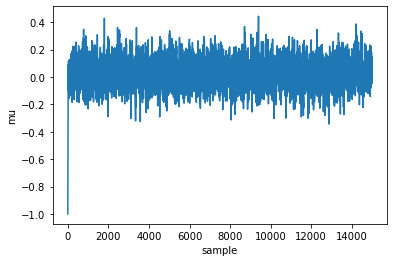

In [21]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=0.1)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

Ideally, our traceplot in each parameter would be **mixing well** (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. **The acceptance rate of new samples should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve**.

Take a look at these plots below (courtesy Steve Taylor from Vanderbilt) for an arbitrary problem. The 1st column is the trace, the 2nd is the histogram of the chain, and the 3rd column is the acceptance rate of newly proposed samples. 

- **In the top row, the proposal width was too small**. The chain hardly moves, giving it a high acceptance rate but poor global exploration of the posterior surface.
- **In the middle row, the proposal width was too big**. The chain proposes new points that are far away from regions of high probability density, meaning that they're hardly ever accepted. The chain gets stuck.
- **Only the bottom row shows reasonable sampling. This is the Goldilocks scenario.**
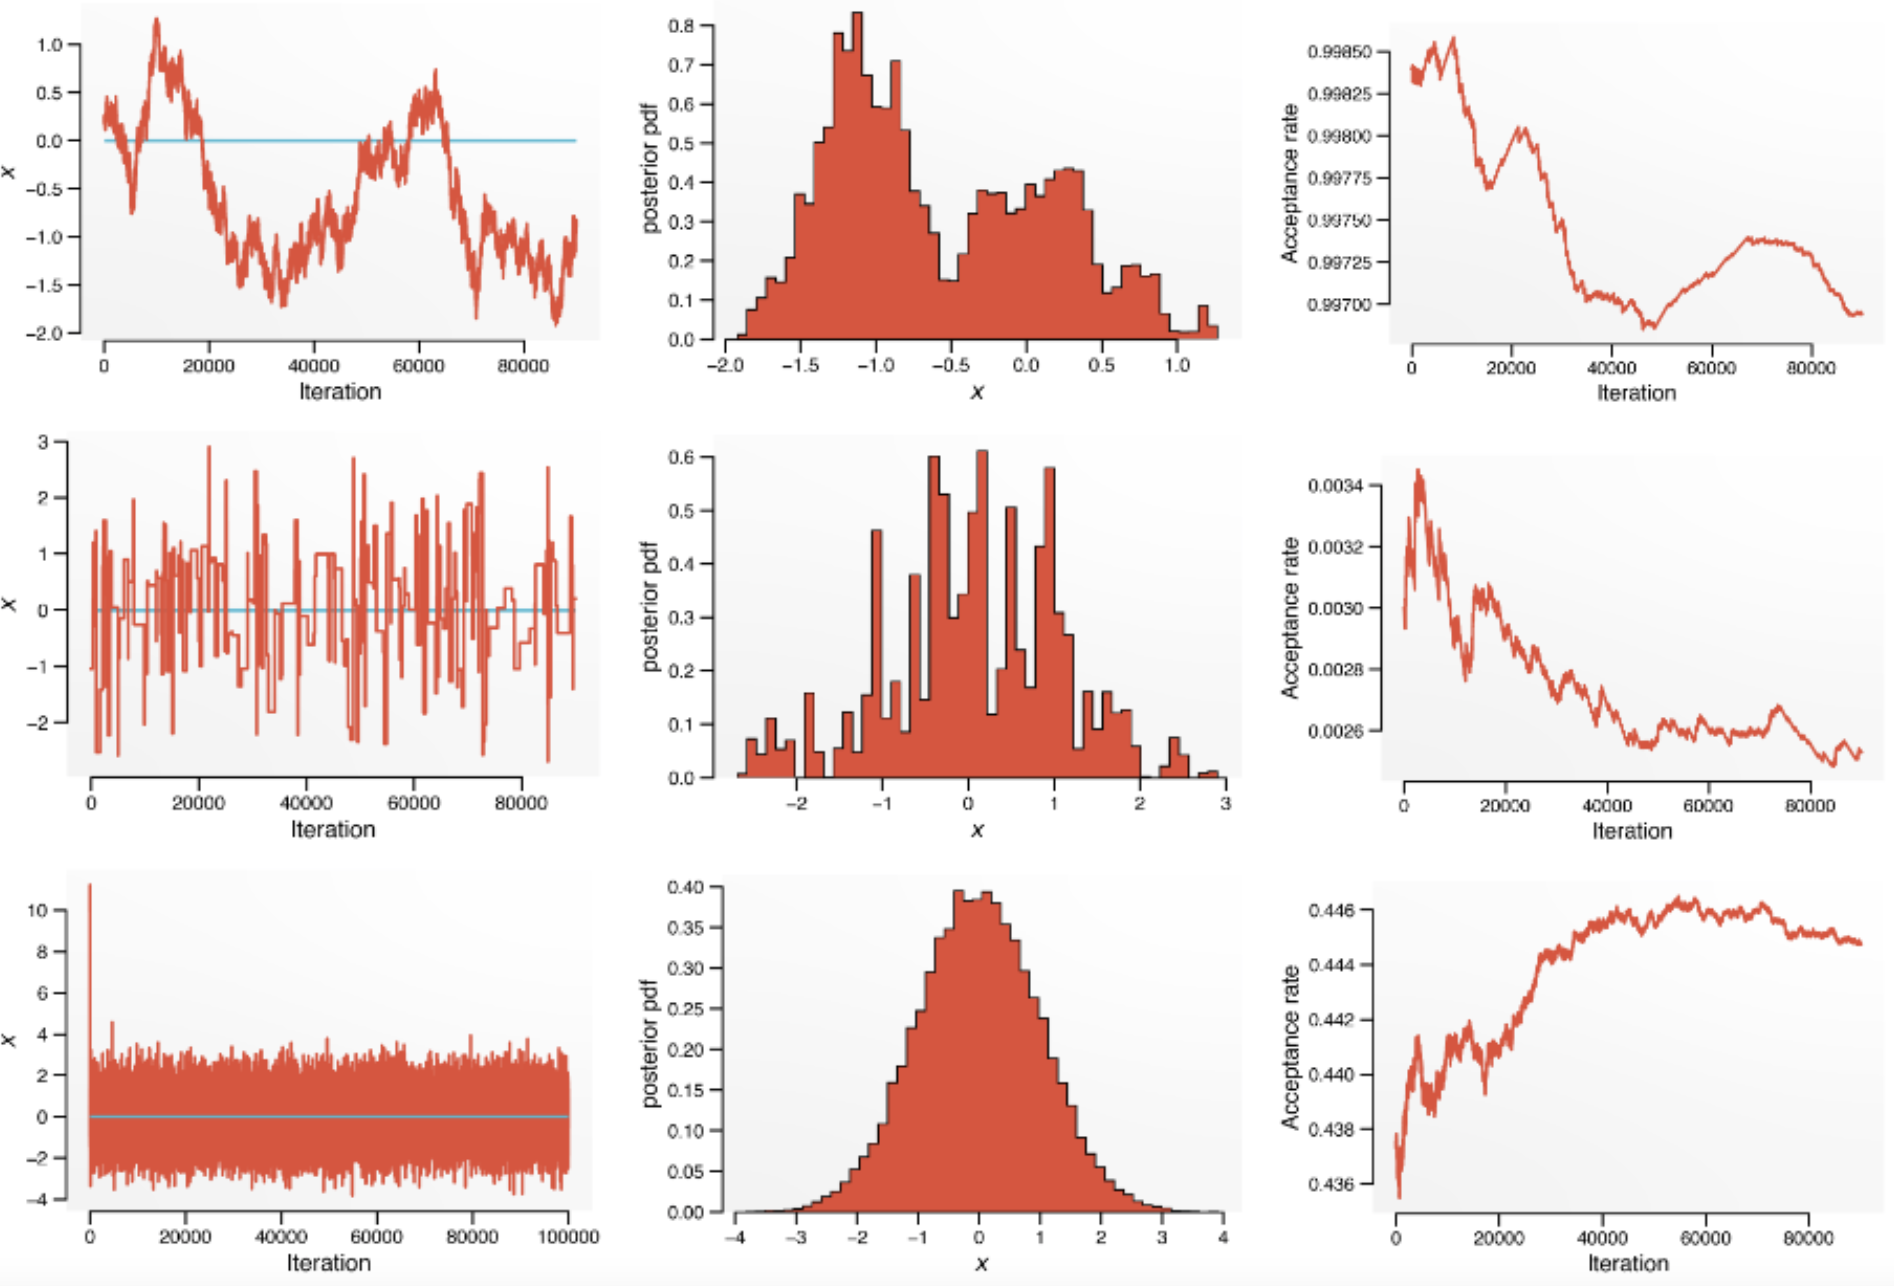
![](./figures/fig_taylor_mcmc.png)

### More Complex Models & Sophisticated Sampling

- The example you worked through above was overkill in that we were only trying to estmate $\mu$. Note also that we can do this in fewer than 10 lines using the ${\tt pymc3}$ module.


- The process is essentially the same when you add more parameters. Check out this [animation of a 2-D process](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) by the same author whose example we just followed.


- Also, check out [this](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=AdaptiveMH&target=multimodal) amazing visualization tool, and have some fun exploring the many different types of sampling algorithms. Metropolis-Hastings is only the start!


- For example in **Adaptive Metropolis-Hastings** the proposal width updates itself in response to the currently-estimate covariance matrix of the MCMC chain. The chain learns how to optimize itself!! 


- We'll look at other algorithms and samplers later this week. There are plenty of tools that a professional astrophysicist can have in their toolbox to tackle research problems.

###  Markov Chain Monte Carlo in Practice

For more involved examples, we will use two popular python modules:
PyMC and emcee. Quoting 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

** emcee **

*The emcee package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

*Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

** PyMC **

*The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. PyMC binaries for many systems can be quite easily installed with conda.*


More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/), but note that we are going to be using [PyMC3](https://docs.pymc.io/).


We will first do an example using emcee and then we will do an example with pyMC.  We won't go over these in class, rather they are provided here for your reference.

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
#from astroML.plotting import hist
#from astroML.plotting.mcmc import convert_to_stdev
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
#from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

###  Markov Chain Monte Carlo with emcee

In [23]:
import emcee
import numpy as np
from scipy import stats
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

def Likelihood(x,sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2/2/sigma**2))

def Prior(x):
    return 1.0/10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data)*Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# the number of trace results will be nwalkers * nsteps
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
Nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, Nburn:, :].reshape(-1, ndim).T

print("done")

done


Text(0.5, 1.0, 'Chain from emcee')

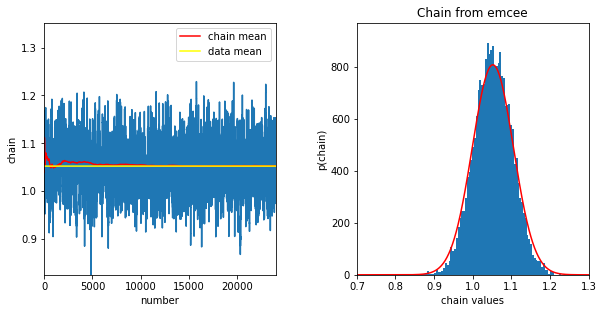

In [24]:
# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

chainE = emcee_trace[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1,M,M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC,c='red',label='chain mean') 
ax1.plot(xgrid, 0*xgrid+np.mean(data),c='yellow',label='data mean')
ax1.legend()

ax2 = fig.add_subplot(122)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chainE[xgrid>Nburn])
Nhist, bins, patches = plt.hist(chainE[xgrid>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee')

###  Markov Chain Monte Carlo with PyMC

Now we will use pyMC3 to get a 2-dimensional posterior pdf 
for location and scale parameters using a sample drawn from 
Cauchy distribution, similar to the distribution we considered earlier using 
brute force grid search method:

In [30]:
# Ivezic v2, Figure 5.22
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import cauchy
from matplotlib import pyplot as plt
#from astroML.plotting.mcmc import convert_to_stdev

import pymc3 as pm

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))


# ----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

# ----------------------------------------------------------------------
# Set up and run MCMC:
with pm.Model():
    mu = pm.Uniform('mu', -5, 5)
    log_gamma = pm.Uniform('log_gamma', -10, 10)

    # set up our observed variable x
    x = pm.Cauchy('x', mu, np.exp(log_gamma), observed=xi)

    trace = pm.sample(draws=12000, tune=1000, cores=1)

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace['mu'],
                                             np.exp(trace['log_gamma']),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(trace['log_gamma']),
                                      bins=gamma_bins, density=True)


# ----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

AttributeError: module 'arviz' has no attribute 'geweke'

Exit Ticket:  Fill in this notebook, including writing the equation for the cubic in the polynomial fitting exmaple.